<a href="https://colab.research.google.com/github/Nanfemicit/EOS-Course/blob/main/Catchment_analysis_exersise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pysheds

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 17.3 MB/s eta 0:00:00
  Created wheel for pysheds: filename=pysheds-0.4-py3-none-any.whl size=90687 sha256=05a7186760c84df35c43c042e2bba997f03f31efb62331ed0be928efff9691b4
  Stored in directory: /root/.cache/pip/wheels/a1/71/eb/89f783658494ca6676dd77fc1b54090a1b748f0055cea65f1c
Successfully built pysheds


In [ ]:
import rasterio
from rasterio.transform import from_bounds

from pysheds.grid import Grid

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import numpy as np
import rasterio
import heapq
import matplotlib.pyplot as plt
import gdown

# Download data

In [ ]:
#'GOOGLE_DRIVE_LINK' to TIFF file
url = 'https://drive.google.com/file/d/1ZS_dK3FfGm8syGeDppD1eu9m9aiCKPlM/view?usp=drive_link'
# Download the TIFF file
file_path = 'dem_Tenerife.tif'
gdown.download(url, file_path, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1ZS_dK3FfGm8syGeDppD1eu9m9aiCKPlM
To: /content/dem_Tenerife.tif
100%|██████████| 57.9M/57.9M [00:00<00:00, 88.8MB/s]


'dem_Tenerife.tif'

# Load Digital Elevation Model (DEM)

In [ ]:
#Load DEM file
dem_file = 'dem_Tenerife.tif'
# Load the DEM data
grid = Grid.from_raster(dem_file, data_name='dem')
dem = grid.read_raster(dem_file)
grid

'affine' : Affine(0.00019500408558752487, 0.0, -16.928728857034894,
       0.0, -0.00019500408558752487, 28.595181954426806)
'shape' : (3079, 4179)
'nodata' : 0.0
'crs' : <Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

'mask' : array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

# Prepare DEM for flow analysis

In [ ]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

# Analyse flow directions and accumulation

In [ ]:
# Compute flow directions - D8 flow directions
fdir = grid.flowdir(inflated_dem)


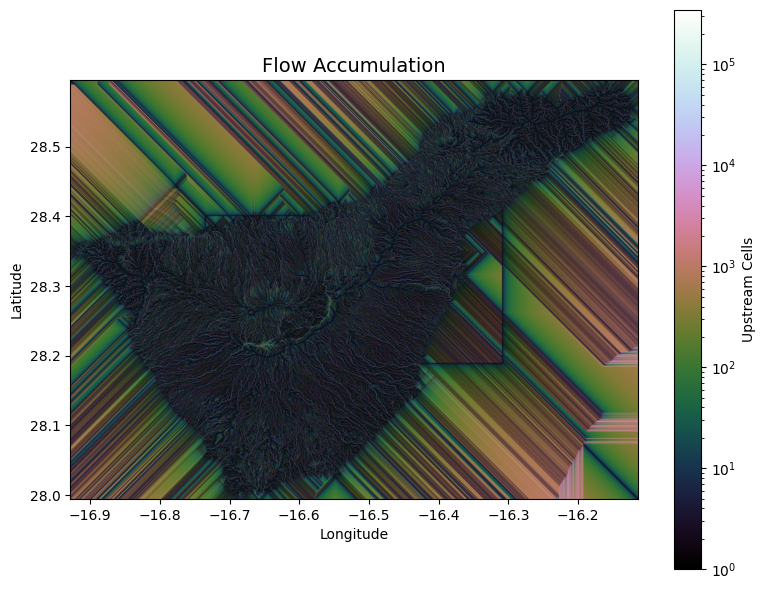

In [ ]:
# Calculate flow accumulation
acc = grid.accumulation(fdir)
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()


We can use the flow accumulation field and load it in GIS to delinate the pure points in our study area

In [ ]:
# We define a flow accumulation threshold to only extract the major stream network
threshold = 1000  # Number of cells contributing to flow
streams = (acc > threshold)*1.0  # Binary mask for stream network

#Save flow accumulation
grid.to_raster(streams,'flow_accumulation.tif')


# Delineate your catchment

In [9]:
#set pour point
lon = -16.2149421
lat = 28.5679804


# Delineate a catchment
# ---------------------
# Specify pour point
x, y = lon, lat

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 100, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, xytype='coordinate')

In [10]:
# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (lon, lat))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, xytype='coordinate')

In [11]:
# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

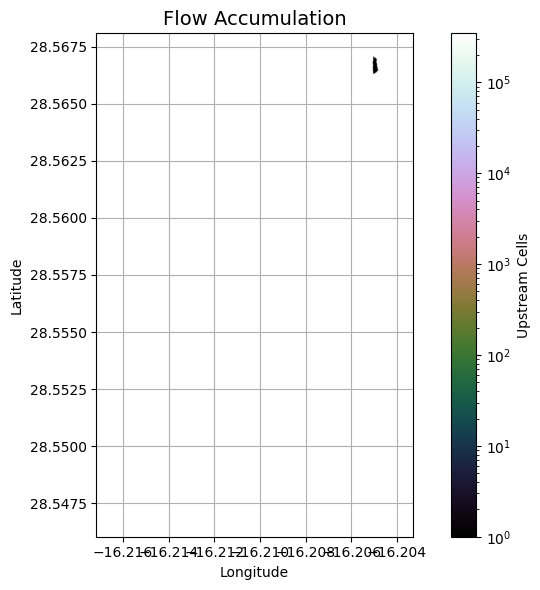

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(catch, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

(array([-16.218, -16.216, -16.214, -16.212, -16.21 , -16.208, -16.206,
        -16.204, -16.202]),
 [Text(-16.218, 0, '−16.218'),
  Text(-16.216, 0, '−16.216'),
  Text(-16.214, 0, '−16.214'),
  Text(-16.212, 0, '−16.212'),
  Text(-16.21, 0, '−16.210'),
  Text(-16.208, 0, '−16.208'),
  Text(-16.206, 0, '−16.206'),
  Text(-16.204, 0, '−16.204'),
  Text(-16.201999999999998, 0, '−16.202')])

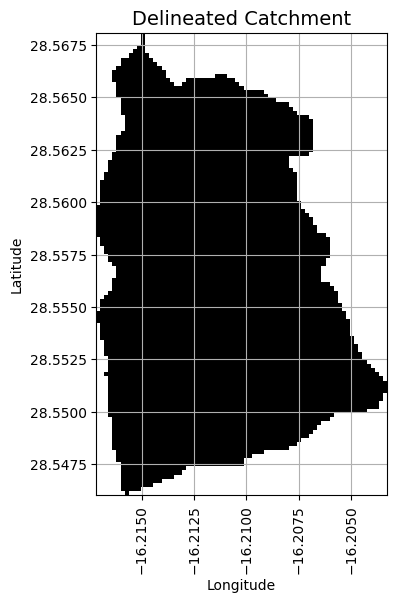

In [13]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)
plt.xticks(rotation=90)

In [14]:
#Save catchment mask
grid.to_raster(clipped_catch.astype(np.int32),'catchment.tif')

# Determine hydrological charateritics for the catchment

In [15]:
# Calculate distance to outlet from each cell
# -------------------------------------------
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, xytype='coordinate')

In [16]:
# Compute flow directions - D8 flow directions only for catchment
# -------------------------------------
fdir = grid.flowdir(inflated_dem)

# A simple flow time model

In [17]:
#Specify grid cell size (here 20m)
L = 20 #length (size) of a grid cell

In [18]:
#drop in height to downstream cell
dh = grid.cell_dh(inflated_dem,fdir)
# prevent no drainage - min slope = 5%
dh[dh<L*0.05] = L*0.05
#approximated flow velocity to neighbouring cell
v = (2.0*9.81*dh)**0.5
#calculate time required to flow through one gird call
t = L/v
# prevent infinit values (dived by zero) - set to nan = not a number
t[np.isinf(t)] = np.nan
# sum up all cells down to outlet
acc_t = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, weights = t)

(array([-16.218, -16.216, -16.214, -16.212, -16.21 , -16.208, -16.206,
        -16.204, -16.202]),
 [Text(-16.218, 0, '−16.218'),
  Text(-16.216, 0, '−16.216'),
  Text(-16.214, 0, '−16.214'),
  Text(-16.212, 0, '−16.212'),
  Text(-16.21, 0, '−16.210'),
  Text(-16.208, 0, '−16.208'),
  Text(-16.206, 0, '−16.206'),
  Text(-16.204, 0, '−16.204'),
  Text(-16.201999999999998, 0, '−16.202')])

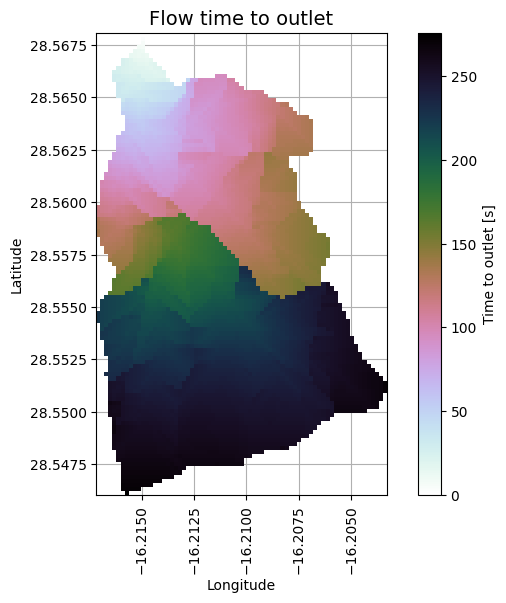

In [19]:
#plot the estimated flow time map
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc_t, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Time to outlet [s]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow time to outlet', size=14)
plt.xticks(rotation=90)

# Generate a flow rate ("discharge") diagram

In [22]:
# Flatten the 2D array to a 1D list
flow_times = acc_t.flatten()

# Remove NaN or infinite values
flow_times = flow_times[np.isfinite(flow_times)]

# Choose time step and unit conversion (options: "seconds", "minutes", "hours")
time_unit = "seconds"  # Change to "seconds" or "hours" as needed

if time_unit == "seconds":
    time_step = 10  # Bin width in seconds
    time_label = "Time to Outlet (seconds)"
elif time_unit == "minutes":
    flow_times = flow_times / 60  # Convert to minutes
    time_step = 1  # Bin width in minutes
    time_label = "Time to Outlet (minutes)"
elif time_unit == "hours":
    flow_times = flow_times / 3600  # Convert to hours
    time_step = 0.1  # Bin width in hours
    time_label = "Time to Outlet (hours)"

# Create bins for histogram
max_time = np.max(flow_times)
bins = np.arange(0, max_time + 2 * time_step, time_step)

# Compute histogram of travel times
discharge, bin_edges = np.histogram(flow_times, bins=bins)

# Get time values (bin centers)
times = bin_edges[:-1]

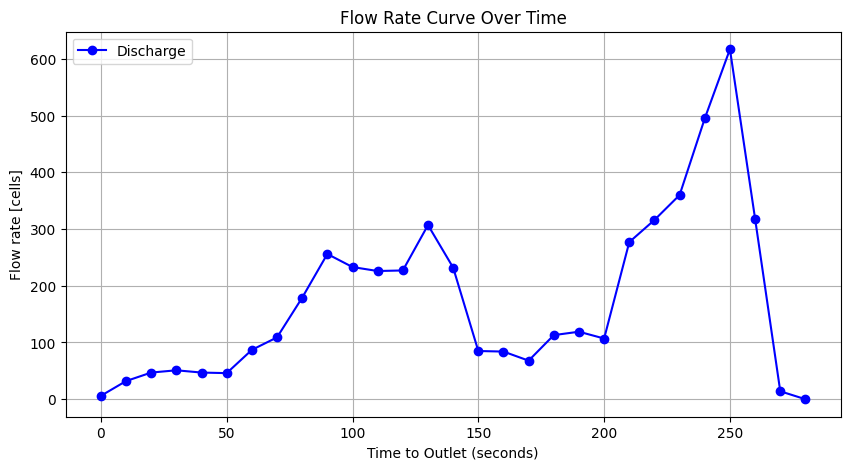

In [23]:
# Plot the discharge curve
plt.figure(figsize=(10, 5))
plt.plot(times, discharge, marker='o', linestyle='-', color='b', label="Discharge")
plt.xlabel(time_label)
plt.ylabel("Flow rate [cells]")
plt.title("Flow Rate Curve Over Time")
plt.grid(True)
plt.legend()
plt.show()